# Convex CNN with Average Pooling and **Vector Output**.

This file implements the convex CNN with arbitrary average pooling and vector output.

Paper: https://arxiv.org/pdf/2101.02429.pdf

In [53]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n-project/daniel/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n-project/daniel


In [54]:
import numpy as np 
import cvxpy as cp
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from time import time
import tqdm.notebook as tq

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn')
plt.rc('axes', labelsize=17)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
C = 5

def load_Fashion_MNIST():
  train_dset = datasets.FashionMNIST('./datasets', train=True, download=True)
  test_dset = datasets.FashionMNIST('./datasets', train=False, download=True)
  X_train =  train_dset.data.numpy()
  y_train = train_dset.targets.numpy()
  X_test = test_dset.data.numpy()
  y_test = test_dset.targets.numpy()

  # We'll do multiclass classification, so get only first C classes
  X_train = X_train[y_train < C]
  y_train = y_train[y_train < C]
  X_test = X_test[y_test < C]
  y_test = y_test[y_test < C]

  # Change type to float
  X_train = X_train.astype(np.float64)
  y_train = y_train.astype(np.float64)
  X_test = X_test.astype(np.float64)
  y_test = y_test.astype(np.float64)

  # Normalize
  X_train = (X_train - 128) / 255
  X_test = (X_test - 128) / 255

  # Expand channel dim
  X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
  X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_Fashion_MNIST()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Uncomment this if in Dev mode
NUM_TRAIN, NUM_TEST = 1250, 5000
X_train, y_train = X_train[:NUM_TRAIN], y_train[:NUM_TRAIN]
X_test, y_test = X_test[:NUM_TEST], y_test[:NUM_TEST]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#####

(30000, 1, 28, 28) (30000,) (5000, 1, 28, 28) (5000,)
(1250, 1, 28, 28) (1250,) (5000, 1, 28, 28) (5000,)


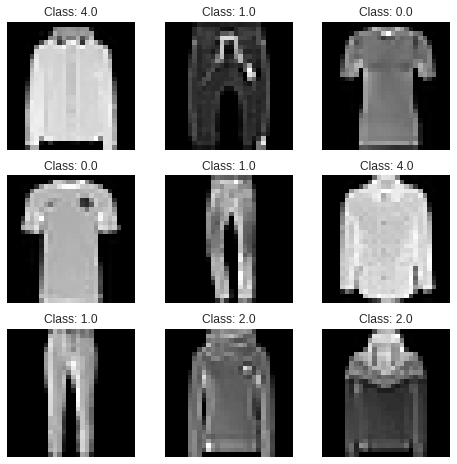

In [63]:
np.random.seed(0)
def visualize_dataset(X, y):
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(X))
    img, label = X[sample_idx], y[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

visualize_dataset(X_train, y_train)

In [64]:
class Convex_CNN_Solver():
  def __init__(self, beta, pool_kernel_size, num_classes, max_iters, filter_size, stride, vectorized):
    '''
    Architecture: One conv layer followed by a fully connected layer
    '''
    self.a, self.b, self.c = 0.09, 0.5, 0.47
    self.beta, self.max_iters = beta, max_iters
    self.F, self.stride = filter_size, stride
    self.vectorized = vectorized

    self.K = None # will be set by self.compute_X_V()
    self.P = pool_kernel_size**2
    self.C = num_classes

    # Solutions
    self.Z_V = None
    self.Z, self.Z_prime = None, None
    self.Z1, self.Z2, self.Z4 = None, None, None
    self.Z1_prime, self.Z2_prime, self.Z4_prime = None, None, None

  def compute_patches(self, X):
    # @ param X: (N, 1, W, W)
    X_P = torch.nn.functional.unfold(torch.tensor(X),
                                     kernel_size=self.F, 
                                     stride=self.stride, 
                                     padding=0).numpy() #(N, D, K)
    self.K = X_P.shape[2]
    return X_P

  def get_Y_expanded(self, y):
    ''' 
    @param y -> (N,)
    @return Y -> (N, C) such that
    Y[i, j] = 1 if y[i] == j else 0
    '''
    y = y.astype(np.long)
    N, C = y.shape[0], self.C
    Y = np.zeros((N, C))
    Y[range(N), y] = 1
    return Y

  def compute_X_V(self, X_P):
    '''
    Calculates X_V in the spirit of Appendix A.

    @param X_P: (N, D, K)
    @return X_V: (N, (D**2+D+1)*(K//P))
    '''
    a, b, c = self.a, self.b, self.c
    N, D, K = X_P.shape
    P = self.P
    assert K % P == 0 # K must be divisible by P

    X_V = np.zeros((N, D**2+D+1, K//P))
    for i in tq.tqdm(range(N)):
      for k in range(K//P):
        for l in range(P):
          r = k*P + l
          x_i_kPl = X_P[i, :, r:r+1]
          X_V[i, 0:D**2, k] += a * (1/P) * (x_i_kPl @ x_i_kPl.T).reshape(D**2)
          X_V[i, D**2:D**2+D, k] += b * (1/P) * x_i_kPl.reshape(D)
    X_V[:, D**2+D, :] = c

    X_V = X_V.reshape((N, (D**2+D+1)*(K//P)))

    return X_V


  def build_Z(self):
    '''
    Note similarity with convex_fc_vector.
    '''
    D, K, P, C = self.F ** 2, self.K, self.P, self.C
    Z, Z_prime, Z_V = [], [], []
    Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime = [], [], [], [], [], []

    for c in range(C):
      Z.append([]); Z_prime.append([]); Z_V.append([])
      Z1.append([]); Z2.append([]); Z4.append([])
      Z1_prime.append([]); Z2_prime.append([]); Z4_prime.append([])
      for k in range(K//P):
        Z1[c] += [cp.Variable((D, D), symmetric=True)]
        Z2[c] += [cp.Variable((D, 1))]
        Z4[c] += [cp.Variable((1, 1))]

        Z1_prime[c] += [cp.Variable((D, D), symmetric=True)]
        Z2_prime[c] += [cp.Variable((D, 1))]
        Z4_prime[c] += [cp.Variable((1, 1))]

        Z[c] += [cp.vstack([
          cp.hstack((Z1[c][k], Z2[c][k])),
          cp.hstack((Z2[c][k].T, Z4[c][k]))
        ])]

        Z_prime[c] += [cp.vstack([
          cp.hstack((Z1_prime[c][k], Z2_prime[c][k])),
          cp.hstack((Z2_prime[c][k].T, Z4_prime[c][k]))
        ])]
      Z_V[c] = cp.hstack([cp.vstack([
        cp.reshape((Z1[c][k]-Z1_prime[c][k]), (D**2, 1)),
        (Z2[c][k]-Z2_prime[c][k]),
        (Z4[c][k]-Z4_prime[c][k])
      ]) for k in range(K//P)]) # (D**2+D+1, K//P)

      Z_V[c] = cp.reshape(Z_V[c], ((D**2+D+1)*(K//P), 1))

    Z_V = cp.hstack([Z_V[c] for c in range(C)]) # shape: ((D**2+D+1)*(K//P), C)

    return Z_V, Z, Z_prime, Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime


  def solve(self, X, y, verbose=True):
    '''
    X.shape = (N, 1, W, W)
    y.shape = (N, )
    '''
    Y = self.get_Y_expanded(y)
    P, C = self.P, self.C
    a, b, c = self.a, self.b, self.c
    X_P = self.compute_patches(X) # (N, D, K)
    N, D, K = X_P.shape
    Z_V, Z, Z_prime, Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime = self.build_Z() # Z_V: ((D**2+D+1)*(K//P), C)
    Y_hat = cp.Variable((N, C))
    constraints = []

    if verbose:
      print(f'X.shape : {X.shape}')    # (N, 1, W, W)
      print(f'Y.shape : {Y.shape}')    # (N, C)
      print(f'X_P.shape: {X_P.shape}') # (N, D, K)
      print(f'Z_V.shape: {Z_V.shape}') # ((D**2+D+1)*(K//P), C)
      print(f'Y_hat.shape: {Y_hat.shape}') # (N, C)

    if self.vectorized:
      X_V = self.compute_X_V(X_P) # (N, (D**2+D+1)*(K//P))
      Y_hat = X_V @ Z_V 
      if verbose:
        print(f'X_V.shape: {X_V.shape}') # (N, (D**2+D+1)*(K//P))
    else:
      for c in range(C):
        for i in range(N):
          Y_ic = 0
          for k in range(K//P):
            quad_term, linear_term, const_term = 0, 0, 0
            for l in range(P):
              r = k*P + l
              x_i_kPl = X_P[i, :, r:r+1]
              quad_term += a * (1/P) * (x_i_kPl.T @ (Z1[c][k] - Z1_prime[c][k]) @ x_i_kPl)
              linear_term += b * (1/P) * x_i_kPl.T @ (Z2[c][k] - Z2_prime[c][k])
            const_term = c * (Z4[c][k] - Z4_prime[c][k])
            Y_ic += quad_term + linear_term + const_term
          constraints += [Y_hat[i, c] == Y_ic]

    data_loss = 0.5 * cp.sum_squares(Y_hat - Y)
    reg_loss = self.beta * sum([Z4[c][k] + Z4_prime[c][k] for k in range(K//P) for c in range(C)])
    loss = data_loss + reg_loss

    objective = cp.Minimize(loss)

    for c in range(C):
      for k in range(K//P):
        constraints += [
            Z[c][k] >> 0,
            Z_prime[c][k] >> 0,
            cp.trace(Z1[c][k]) == Z4[c][k],
            cp.trace(Z1_prime[c][k]) == Z4_prime[c][k],
        ]

    problem = cp.Problem(objective, constraints)
    print(f'##########')
    print('Started...')
    start = time()
    problem.solve(max_iters=self.max_iters, verbose=verbose)
    end = time()
    print(f'Finished, time: {end-start}')
    print(f'status: {problem.status}')
    print(f'optimal value: {objective.value}')
    print('##########')

    # Save solutions
    self.Z_V = Z_V.value
    self.Z, self.Z_prime = self.values(Z),  self.values(Z_prime)
    self.Z1, self.Z2, self.Z4 = self.values(Z1), self.values(Z2), self.values(Z4)
    self.Z1_prime, self.Z2_prime, self.Z4_prime = self.values(Z1_prime), self.values(Z2_prime), self.values(Z4_prime)

    return end-start
  
  def values(self, arr):
    C, K, P = self.C, self.K, self.P
    return np.array([[arr[c][k].value for k in range(K//P)] for c in range(C)])

  def predict(self, X):
    X_P = self.compute_patches(X)
    if self.vectorized:
      X_V = self.compute_X_V(X_P)
      Y_hat = X_V @ self.Z_V
    else:
      N, D, K = X_P.shape
      P, C = self.P, self.C
      a, b, c = self.a, self.b, self.c
      Z1, Z2, Z4 = self.Z1, self.Z2, self.Z4
      Z1_prime, Z2_prime, Z4_prime = self.Z1_prime, self.Z2_prime, self.Z4_prime
      Y_hat = np.zeros((N, C))
      for c in range(C):
        for i in range(N):
          Y_ic = 0
          for k in range(K//P):
            quad_term, linear_term, const_term = 0, 0, 0
            for l in range(P):
              r = k*P + l
              x_i_kPl = X_P[i, :, r:r+1]
              quad_term += a * (1/P) * (x_i_kPl.T @ (Z1[c][k] - Z1_prime[c][k]) @ x_i_kPl)
              linear_term += b * (1/P) * x_i_kPl.T @ (Z2[c][k] - Z2_prime[c][k])
            const_term = c * (Z4[c][k] - Z4_prime[c][k])
            Y_ic += quad_term + linear_term + const_term
          Y_hat[i, c] = Y_ic
    return Y_hat

  def calculate_loss(self, Y_hat, y):
    Y = self.get_Y_expanded(y)
    loss = 0.5 * np.sum((Y - Y_hat)**2) + self.beta * np.sum(self.Z4 + self.Z4_prime)
    return loss.squeeze()

  def get_num_neurons(self, tolerance: float):
    count = 0
    C, K, P = self.C, self.K, self.P
    Z, Z_prime = self.Z, self.Z_prime
    for c in range(C):
      for k in range(K//P):
          eigvals1, _ = np.linalg.eig(Z[c][k])
          eigvals2, _ = np.linalg.eig(Z_prime[c][k])
          count += np.sum(eigvals1 > tolerance) + np.sum(eigvals2 > tolerance)
    return count

In [65]:
solver = Convex_CNN_Solver(beta=10**(-6), pool_kernel_size=13, num_classes=C, max_iters=1000, filter_size=3, stride=1, vectorized=True)
time_elapsed = solver.solve(X_train, y_train, verbose=True)

X.shape : (1250, 1, 28, 28)
Y.shape : (1250, 5)
X_P.shape: (1250, 9, 676)
Z_V.shape: (364, 5)
Y_hat.shape: (1250, 5)



X_V.shape: (1250, 364)
##########
Started...
----------------------------------------------------------------------------
	SCS v2.1.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 2752602
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 2201, constraints m = 8492
Cones:	primal zero / dual free vars: 40
	soc vars: 6252, soc blks: 1
	sd vars: 2200, sd blks: 40
Setup time: 1.24e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.85e+20  9.65e+19  1.00e+00 -2.55e+21  3.97e+21  3.97e+21  5.92e-02 
   100| 1.27e-01  1.89e-01  8.63e-05  1.60e+02  1.60e+02  6.46e-17  1.83e+00 
 

In [66]:
scores = solver.predict(X_train)
y_pred = scores.argmax(axis=1)
accuracy = np.sum(y_pred == y_train) / y_train.shape[0]
loss = solver.calculate_loss(scores, y_train)
print(f'train_accuracy: {accuracy}')
print(f'loss: {loss}')


train_accuracy: 0.9016
loss: 146.8089606612352


In [67]:
scores = solver.predict(X_test)
y_pred = scores.argmax(axis=1)
accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
loss = solver.calculate_loss(scores, y_test)
print(f'test_accuracy: {accuracy}')
print(f'loss: {loss}')


test_accuracy: 0.8136
loss: 910.2441551228004


In [68]:
print(f'num_neurons: {solver.get_num_neurons(tolerance=10**(-6))}')

num_neurons: 344
